### Introduction

The goal of this notebook is to build from scratch a neural network for an image classficiation task.

This is to have a good grasp of deep learning concepts ..

## Plan

**1-** Prepare the dataset

**2-** Implementing the forward pass

**3-** Implementing the backwad pass

**4-** Evaluating the performance of the nn

**5-** Experiments with the nn parametres and how they affect the performances 

Some questions that we want to answer are : 

* Can we find some correlation between the variance in the dataset and the size of the neural network? 
* Is the bias part of the neurons important in the task?
* Does the activation function affects the value to be choosen for the learning rate

## 1-  Loading the dataset

In [149]:
import tensorflow as tf

# Load the MNIST dataset                                
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Shuffle the training data
indices = tf.range(start=0, limit=tf.shape(x_train)[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices)

x_train = tf.gather(x_train, shuffled_indices)
y_train = tf.gather(y_train, shuffled_indices)

# Convert tensors back to numpy arrays
x_train = x_train.numpy()
y_train = y_train.numpy()

# Display the shape of the loaded data
print("Training data shape:", x_train.shape)  # (60000, 28, 28)
print("Training labels shape:", y_train.shape)  # (60000,)
print("Test data shape:", x_test.shape)  # (10000, 28, 28)
print("Test labels shape:", y_test.shape)  # (10000,)

Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)


##  2-  Visualizing the dataset

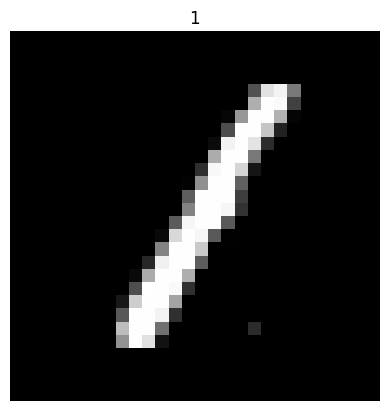

In [150]:
import matplotlib.pyplot as plt
import numpy as np

random_idx = np.random.randint(1000)

image = x_train[random_idx]
label = y_train[random_idx]


def visualize_image(image, label):
    plt.imshow(image, cmap='gray')  # Display the image
    plt.axis('off')  # Turn off the axes
    plt.title(label)
    plt.show()  # Show the image
    
visualize_image(image, label)

==> Each image is a **28*28** pixels, which gives a list of **784** elements

## 3- Implementing the forward pass

Our neural network, would be such that there is only one hidden layer with **300** neurons, and the output layer with **10**neurons

For now, the activations functions would be all linear, and in to generate the output we take the argmax.

Our loss function will be the Mean Squared Error, aka **MSE**

In [151]:
input_layer = image.flatten()

In [152]:
## Initializing the weights linking the input layer with the hidden layer

size_input_layer = len(input_layer) #784
size_hidden_layer = 25
size_output_layer = 10
print(len(input_layer))

def init_weights():
    weight_input_hidden = np.random.random((size_input_layer, size_hidden_layer))
    weight_hidden_output = np.random.random((size_hidden_layer, size_output_layer))
    
    return weight_input_hidden, weight_hidden_output

weight_input_hidden, weight_hidden_output = init_weights()
weights = weight_input_hidden, weight_hidden_output

784


In [153]:
def init_weights_he():
    # He initialization for weight_input_hidden
    limit_input_hidden = np.sqrt(2 / size_input_layer)
    weight_input_hidden = np.random.randn(size_input_layer, size_hidden_layer) * limit_input_hidden
    
    # He initialization for weight_hidden_output
    limit_hidden_output = np.sqrt(2 / size_hidden_layer)
    weight_hidden_output = np.random.randn(size_hidden_layer, size_output_layer) * limit_hidden_output
    
    return weight_input_hidden, weight_hidden_output


In [154]:
def init_weights_xavier():
    # Xavier initialization for weight_input_hidden
    limit_input_hidden = np.sqrt(6 / (size_input_layer + size_hidden_layer))
    weight_input_hidden = np.random.uniform(-limit_input_hidden, limit_input_hidden, 
                                            (size_input_layer, size_hidden_layer))
    
    # Xavier initialization for weight_hidden_output
    limit_hidden_output = np.sqrt(6 / (size_hidden_layer + size_output_layer))
    weight_hidden_output = np.random.uniform(-limit_hidden_output, limit_hidden_output, 
                                             (size_hidden_layer, size_output_layer))
    
    return weight_input_hidden, weight_hidden_output

# Test the initialization
weights_xavier = init_weights_xavier()
weights_xavier[0].shape, weights_xavier[1].shape  # Just to check if the shapes are correct


((784, 25), (25, 10))

In [155]:
# Hidden layer result
hidden_representation = np.dot(input_layer, weight_input_hidden)

# Min max normalization
mi = hidden_representation.min()
ma = hidden_representation.max()

# min max normalization
norm_hidden_representation = (hidden_representation - mi)/(ma-mi)

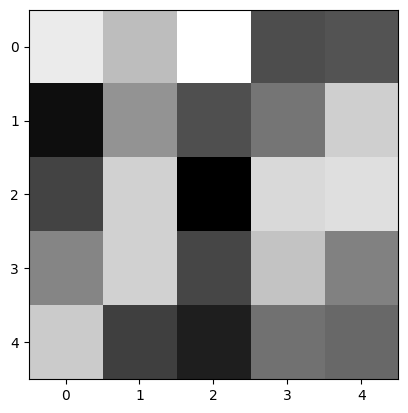

In [156]:
import math
plt.imshow(norm_hidden_representation.reshape(int(math.sqrt(size_hidden_layer)),int(math.sqrt(size_hidden_layer))), cmap='gray')  # Display the image

In [157]:
## hidden output result 

ouput_result = np.dot(norm_hidden_representation, weight_hidden_output)
ouput_result.shape

(10,)

In [158]:
# Result of the forward pass
ouput_result.argmax()

2

In [159]:
# Defining the function that takes as an input the input layer(vector) and parameters and returns the predicted written number
def predict_number(input_layer, weights):
    
    weights = weight_input_hidden, weight_hidden_output

    hidden_representation = np.dot(input_layer, weight_input_hidden)
    mi = hidden_representation.min()
    ma = hidden_representation.max()

    # min max normalization
    norm_hidden_representation = (hidden_representation - mi)/(ma-mi)

    ouput_result = np.dot(norm_hidden_representation, weight_hidden_output)
    # Result of the forward pass
    result = ouput_result.argmax()
    return result


In [160]:
# Defining the function that takes as an input the input layer(vector) and parameters and returns the hidden representation and the output result
def forward_pass(input_layer, weights):
    
    weight_input_hidden, weight_hidden_output = weights
    
    hidden_representation = np.dot(input_layer, weight_input_hidden)
    
    mean = np.mean(hidden_representation)
    variance = np.var(hidden_representation)
    epsilon = 10 **(-5)
    scaled_hidden_representation = (hidden_representation - mean)/np.sqrt(variance + epsilon)

    output_result = np.dot(scaled_hidden_representation, weight_hidden_output)
    
    return scaled_hidden_representation, output_result

In [161]:
def forward_pass_dropout(input_layer, weights, p=0.5, training=True):
    weight_input_hidden, weight_hidden_output = weights
    
    # Flatten the input_layer
    input_layer = input_layer.flatten()
    
    # Compute the hidden representation
    hidden_representation = np.dot(input_layer, weight_input_hidden)
    
    # Apply dropout to the hidden representation during training
    if training:
        mask = (np.random.rand(*hidden_representation.shape) > p).astype(np.float32)
        hidden_representation = hidden_representation * mask / (1-p)
    else:
        mask = None
    
    # Normalize the hidden representation
    mean = np.mean(hidden_representation)
    variance = np.var(hidden_representation)
    epsilon = 10 **(-5)
    scaled_hidden_representation = (hidden_representation - mean)/np.sqrt(variance + epsilon)

    output_result = np.dot(scaled_hidden_representation, weight_hidden_output)
    
    return scaled_hidden_representation, output_result, mask

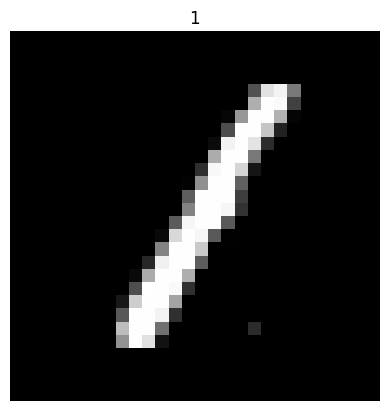

(25,)

In [162]:
#Test
visualize_image(image, label)
forward_pass(input_layer, weights)[0].shape

## 4- Implementing the backward pass:

This section would modify the *input_hidden_weights* and *hidden_output_weights* in order to make better predictions.

The weights modifications would be based on the backpropagation algorithms

In [163]:
def MSE(predicted, desired):
    # This function takes as input numpy arrays and not lists
    diff = 1/2 * ((predicted - desired)**2).sum()
    return diff

In [164]:
def full_backward_pass(weights, image, label, lr = 0.01, lamda = 0.01):
    # We only modify the weights between the last and the penultimate layer
    # weights is a tuple of matrices : weight_input_hidden & weight_hidden_output

    size_hidden_layer = 300
    size_output_layer = 10

    # one hot encoding the label
    desired = np.zeros(size_output_layer)
    desired[int(label)] = 1

    weight_input_hidden, weight_hidden_output = weights
    new_weight_input_hidden, new_weight_hidden_output = weight_input_hidden.copy(), weight_hidden_output.copy()

    input_layer = image.flatten() # flattening the image

    hidden_representation, output_result = forward_pass(input_layer, (weight_input_hidden, weight_hidden_output)) # forward pass

    output_result =  tf.nn.softmax(output_result) # softmax operation

    delta_matrix = np.zeros((size_hidden_layer, size_output_layer))

    # gradient descent iteration # backward pass for the second layer
    for k in range(size_output_layer):
        for j in range(size_hidden_layer):
            delta = (output_result[k] - desired[k]) * hidden_representation[j] * (1 - output_result[k]) * output_result[k]
            new_weight_hidden_output[j][k] = (1-lamda) * new_weight_hidden_output[j][k] - lr*delta

            delta_matrix[j][k] = delta

    for j in range(size_hidden_layer):
        for i in range(size_input_layer):
            delta = np.sum(new_weight_hidden_output[j]* (delta_matrix[j]) * input_layer[i] / hidden_representation[j])
            new_weight_input_hidden[i][j] = (1-lamda) * new_weight_input_hidden[i][j] - lr*delta


    return new_weight_input_hidden, new_weight_hidden_output

In [165]:
def full_backward_pass_cross_entropy(weights, image, label, lr=0.01, lamda=0.01):
    size_hidden_layer = 300
    size_output_layer = 10

    # one hot encoding the label
    desired = np.zeros(size_output_layer)
    desired[int(label)] = 1

    weight_input_hidden, weight_hidden_output = weights
    new_weight_input_hidden, new_weight_hidden_output = weight_input_hidden.copy(), weight_hidden_output.copy()

    input_layer = image.flatten()  # flattening the image

    hidden_representation, logits = forward_pass(input_layer, (weight_input_hidden, weight_hidden_output))  # forward pass
    output_result = tf.nn.softmax(logits)  # softmax operation

    # Gradient of cross-entropy loss w.r.t. logits
    d_logits = output_result - desired

    # Backward pass for the second layer
    d_weight_hidden_output = np.outer(hidden_representation, d_logits)
    new_weight_hidden_output = (1 - lamda) * weight_hidden_output - lr * d_weight_hidden_output

    # Backward pass for the first layer
    d_hidden_representation = np.dot(d_logits, weight_hidden_output.T)
    d_weight_input_hidden = np.outer(input_layer, d_hidden_representation)
    new_weight_input_hidden = (1 - lamda) * weight_input_hidden - lr * d_weight_input_hidden

    return new_weight_input_hidden, new_weight_hidden_output

In [166]:
def full_backward_pass_cross_entropy_adam(weights, image, label, t, m_prev_1, m_prev_2, v_prev_1, v_prev_2, lr=0.001, lamda=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
    size_hidden_layer = 300
    size_output_layer = 10

    # one hot encoding the label
    desired = np.zeros(size_output_layer)
    desired[int(label)] = 1

    weight_input_hidden, weight_hidden_output = weights

    input_layer = image.flatten()  # flattening the image
    hidden_representation, logits = forward_pass(input_layer, (weight_input_hidden, weight_hidden_output))  # forward pass
    output_result = tf.nn.softmax(logits)  # softmax operation

    # Gradient of cross-entropy loss w.r.t. logits
    d_logits = output_result - desired

    # Backward pass for the second layer
    d_weight_hidden_output = np.outer(hidden_representation, d_logits)
    # Adam for weight_hidden_output
    m_t_2 = beta1 * m_prev_2 + (1 - beta1) * d_weight_hidden_output
    v_t_2 = beta2 * v_prev_2 + (1 - beta2) * d_weight_hidden_output**2
    m_t_hat_2 = m_t_2 / (1 - beta1**t)
    v_t_hat_2 = v_t_2 / (1 - beta2**t)
    new_weight_hidden_output = weight_hidden_output - lr * m_t_hat_2 / (np.sqrt(v_t_hat_2) + epsilon)

    # Backward pass for the first layer
    d_hidden_representation = np.dot(d_logits, weight_hidden_output.T)
    d_weight_input_hidden = np.outer(input_layer, d_hidden_representation)
    # Adam for weight_input_hidden
    m_t_1 = beta1 * m_prev_1 + (1 - beta1) * d_weight_input_hidden
    v_t_1 = beta2 * v_prev_1 + (1 - beta2) * d_weight_input_hidden**2
    m_t_hat_1 = m_t_1 / (1 - beta1**t)
    v_t_hat_1 = v_t_1 / (1 - beta2**t)
    new_weight_input_hidden = weight_input_hidden - lr * m_t_hat_1 / (np.sqrt(v_t_hat_1) + epsilon)

    return new_weight_input_hidden, new_weight_hidden_output, m_t_1, m_t_2, v_t_1, v_t_2

# Note: This function now also returns the updated moments m and v for both layers, which should be passed in the next call for updates.


In [167]:
def full_backward_pass_cross_entropy_adam_dropout(weights, image, label, mask, t, m_prev_1, m_prev_2, v_prev_1, v_prev_2, lr=0.001, lamda=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
   

    desired = np.zeros(size_output_layer)
    desired[int(label)] = 1

    weight_input_hidden, weight_hidden_output = weights
    input_layer = image.flatten()
    hidden_representation, logits, _ = forward_pass_dropout(input_layer, (weight_input_hidden, weight_hidden_output))
    output_result = tf.nn.softmax(logits)

    d_logits = output_result - desired
    d_weight_hidden_output = np.outer(hidden_representation, d_logits)

    m_t_2 = beta1 * m_prev_2 + (1 - beta1) * d_weight_hidden_output
    v_t_2 = beta2 * v_prev_2 + (1 - beta2) * d_weight_hidden_output**2
    m_t_hat_2 = m_t_2 / (1 - beta1**t)
    v_t_hat_2 = v_t_2 / (1 - beta2**t)
    new_weight_hidden_output = weight_hidden_output - lr * m_t_hat_2 / (np.sqrt(v_t_hat_2) + epsilon)

    d_hidden_representation = np.dot(d_logits, weight_hidden_output.T) * mask
    d_weight_input_hidden = np.outer(input_layer, d_hidden_representation)

    m_t_1 = beta1 * m_prev_1 + (1 - beta1) * d_weight_input_hidden
    v_t_1 = beta2 * v_prev_1 + (1 - beta2) * d_weight_input_hidden**2
    m_t_hat_1 = m_t_1 / (1 - beta1**t)
    v_t_hat_1 = v_t_1 / (1 - beta2**t)
    new_weight_input_hidden = weight_input_hidden - lr * m_t_hat_1 / (np.sqrt(v_t_hat_1) + epsilon)

    return new_weight_input_hidden, new_weight_hidden_output, m_t_1, m_t_2, v_t_1, v_t_2

In [168]:
# testing the backward pass 

# preparing the args
random_idx += 1 

image = x_train[random_idx]; input_layer = image.flatten()
label = y_train[random_idx]

# one hot encoding
desired = np.zeros(size_output_layer)
desired[int(label)] = 1

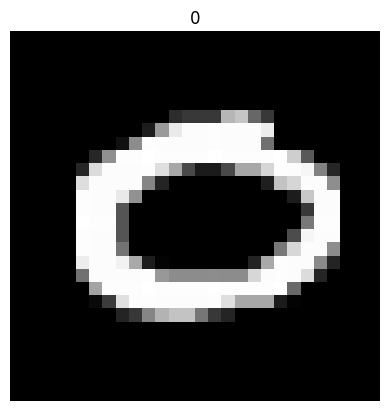

In [169]:
visualize_image(image, label)

In [170]:
# skip if you don't want to perform the backward pass
# new_weight_input_hidden, new_weight_hidden_output = full_backward_pass(weights, image, label)

In [171]:
# _, new_output = forward_pass(input_layer, (new_weight_input_hidden, new_weight_hidden_output))
# norm_new_output = np.array(tf.nn.softmax(new_output)) # transforming the logits to probs
# MSE(norm_new_output, desired)

In [172]:
# _, old_output = forward_pass(input_layer, (weight_input_hidden, weight_hidden_output))
# norm_old_output = np.array(tf.nn.softmax(old_output))
# MSE(norm_old_output, desired)

In [173]:
# new_output

## 5 - Training and Validation loop:

In [174]:
from tqdm import tqdm

def train(weights, train_data, val_data=None):
    weight_input_hidden, weight_hidden_output = weights
    images, labels = train_data
    
    # List to store weights periodically
    saved_weights = []

    for idx, (image, label) in tqdm(enumerate(zip(images, labels))):
        new_weight_input_hidden, new_weight_hidden_output = full_backward_pass_cross_entropy(weights, image, label)
        weights = new_weight_input_hidden, new_weight_hidden_output
        
        # Save weights every N iterations (e.g., every 10 images)
        if idx % 10 == 0:
            saved_weights.append(new_weight_input_hidden.copy())  
        
        if val_data and (idx % 3 == 0) and (idx != 0):
            metric_value = validate(weights, val_data)
            print(f"Metric value: {idx}th image (number: {label}): {metric_value}")

    return weights, saved_weights


In [175]:
def train_adam(weights, train_data, val_data=None, lr=0.001, lamda=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
    weight_input_hidden, weight_hidden_output = weights
    images, labels = train_data
    
    # List to store weights periodically
    saved_weights = []

    # Initialize moments for Adam optimizer
    m_prev_1 = np.zeros_like(weight_input_hidden)
    m_prev_2 = np.zeros_like(weight_hidden_output)
    v_prev_1 = np.zeros_like(weight_input_hidden)
    v_prev_2 = np.zeros_like(weight_hidden_output)
    
    for idx, (image, label) in tqdm(enumerate(zip(images, labels))):
        new_weight_input_hidden, new_weight_hidden_output, m_prev_1, m_prev_2, v_prev_1, v_prev_2 = full_backward_pass_cross_entropy_adam(
            weights, image, label, idx+1, m_prev_1, m_prev_2, v_prev_1, v_prev_2, lr, lamda, beta1, beta2, epsilon
        )
        weights = new_weight_input_hidden, new_weight_hidden_output
        
        # Save weights every N iterations (e.g., every 10 images)
        if idx % 10 == 0:
            saved_weights.append(new_weight_input_hidden.copy())  
        
        if val_data and (idx % 10 == 0) and (idx != 0):
            metric_value = validate(weights, val_data)
            print(f"Metric value: {idx}th image (number: {label}): {metric_value}")

    return weights, saved_weights

In [176]:
def train_dropout(weights, train_data, val_data=None):
    weight_input_hidden, weight_hidden_output = weights
    images, labels = train_data
    saved_weights = []

    # Initialize moments for Adam optimizer
    m_prev_1 = np.zeros_like(weight_input_hidden)
    m_prev_2 = np.zeros_like(weight_hidden_output)
    v_prev_1 = np.zeros_like(weight_input_hidden)
    v_prev_2 = np.zeros_like(weight_hidden_output)

    for idx, (image, label) in tqdm(enumerate(zip(images, labels))):
        _, _, mask = forward_pass_dropout(image, weights)
        new_weight_input_hidden, new_weight_hidden_output, m_prev_1, m_prev_2, v_prev_1, v_prev_2 = full_backward_pass_cross_entropy_adam_dropout(
            weights, image, label, mask, idx+1, m_prev_1, m_prev_2, v_prev_1, v_prev_2
        )
        weights = new_weight_input_hidden, new_weight_hidden_output

        if idx % 10 == 0:
            saved_weights.append(new_weight_input_hidden.copy())

        if val_data and (idx % 20 == 0) and (idx != 0):
            metric_value = validate_dropout(weights, val_data)
            print(f"Metric value: {idx}th image (number: {label}): {metric_value}")

    return weights, saved_weights

In [177]:
def validate(weights, val_data):
    weight_input_hidden, weight_hidden_output = weights
    images, labels = val_data
    
    predicted_labels = []
    for image in images:
        input_layer = image.flatten()
        _, logits = forward_pass(input_layer, weights)
        predicted_label = np.argmax(logits)
        predicted_labels.append(predicted_label)
        
    return sum(predicted_labels == labels)/labels.shape[0]

In [178]:
def validate_dropout(weights, val_data):
    weight_input_hidden, weight_hidden_output = weights
    images, labels = val_data
    
    predicted_labels = []
    for image in images:
        _, logits, _ = forward_pass_dropout(image, weights, training=False)
        predicted_label = np.argmax(logits)
        predicted_labels.append(predicted_label)
        
    return sum(predicted_labels == labels)/labels.shape[0]



In [179]:
# Preparing data
train_size = 6000
val_size = 2000

train_data = x_train[1000 :1000 +train_size], y_train[1000: 1000 + train_size]
val_data = x_test[:val_size], y_test[:val_size]
# weights_init_xavier = init_weights_xavier()
weights_init_he = init_weights_he()
# weights_init = init_weights()
# weights = weights_init_he

In [192]:
val_size = 2000
val_data = x_test[:val_size], y_test[:val_size]

In [193]:
weights = weights_init_he

In [194]:
weights, saved_weights = train_dropout(weights, train_data, val_data)

0it [00:00, ?it/s]

34it [00:00, 46.99it/s] 

Metric value: 20th image (number: 5): 0.1285


43it [00:01, 27.69it/s]

Metric value: 40th image (number: 5): 0.1645


61it [00:01, 29.66it/s]

Metric value: 60th image (number: 7): 0.2095


81it [00:02, 34.11it/s]

Metric value: 80th image (number: 8): 0.2415


101it [00:02, 36.62it/s]

Metric value: 100th image (number: 2): 0.2845


121it [00:03, 38.40it/s]

Metric value: 120th image (number: 1): 0.297


141it [00:03, 38.32it/s]

Metric value: 140th image (number: 2): 0.3605


161it [00:04, 36.88it/s]

Metric value: 160th image (number: 2): 0.4105


181it [00:04, 38.04it/s]

Metric value: 180th image (number: 8): 0.4265


201it [00:05, 40.17it/s]

Metric value: 200th image (number: 7): 0.511


221it [00:05, 41.85it/s]

Metric value: 220th image (number: 3): 0.519


241it [00:06, 38.14it/s]

Metric value: 240th image (number: 2): 0.468


261it [00:06, 38.33it/s]

Metric value: 260th image (number: 1): 0.478


281it [00:07, 40.21it/s]

Metric value: 280th image (number: 2): 0.48


301it [00:07, 41.20it/s]

Metric value: 300th image (number: 0): 0.594


321it [00:08, 40.60it/s]

Metric value: 320th image (number: 4): 0.6055


341it [00:08, 41.77it/s]

Metric value: 340th image (number: 2): 0.5885


361it [00:09, 42.46it/s]

Metric value: 360th image (number: 8): 0.626


381it [00:09, 43.12it/s]

Metric value: 380th image (number: 5): 0.621


401it [00:10, 39.72it/s]

Metric value: 400th image (number: 5): 0.649


421it [00:10, 36.35it/s]

Metric value: 420th image (number: 2): 0.68


441it [00:11, 37.56it/s]

Metric value: 440th image (number: 5): 0.664


461it [00:11, 38.35it/s]

Metric value: 460th image (number: 7): 0.651


481it [00:12, 37.14it/s]

Metric value: 480th image (number: 4): 0.644


501it [00:12, 37.57it/s]

Metric value: 500th image (number: 3): 0.63


521it [00:13, 40.01it/s]

Metric value: 520th image (number: 8): 0.655


541it [00:13, 40.82it/s]

Metric value: 540th image (number: 6): 0.6715


561it [00:14, 40.67it/s]

Metric value: 560th image (number: 4): 0.7165


581it [00:14, 42.50it/s]

Metric value: 580th image (number: 0): 0.705


601it [00:15, 42.76it/s]

Metric value: 600th image (number: 4): 0.7025


621it [00:15, 36.64it/s]

Metric value: 620th image (number: 3): 0.729


641it [00:16, 39.00it/s]

Metric value: 640th image (number: 2): 0.755


661it [00:16, 40.71it/s]

Metric value: 660th image (number: 2): 0.741


681it [00:17, 42.03it/s]

Metric value: 680th image (number: 4): 0.745


701it [00:17, 42.45it/s]

Metric value: 700th image (number: 1): 0.74


721it [00:18, 39.51it/s]

Metric value: 720th image (number: 0): 0.7505


741it [00:18, 38.31it/s]

Metric value: 740th image (number: 9): 0.748


761it [00:19, 40.04it/s]

Metric value: 760th image (number: 2): 0.7405


781it [00:19, 41.55it/s]

Metric value: 780th image (number: 2): 0.7425


801it [00:20, 42.98it/s]

Metric value: 800th image (number: 6): 0.7405


821it [00:20, 43.89it/s]

Metric value: 820th image (number: 5): 0.7475


841it [00:21, 40.11it/s]

Metric value: 840th image (number: 5): 0.7455


861it [00:21, 35.36it/s]

Metric value: 860th image (number: 1): 0.759


881it [00:22, 35.85it/s]

Metric value: 880th image (number: 6): 0.7515


901it [00:23, 31.43it/s]

Metric value: 900th image (number: 6): 0.7335


921it [00:23, 33.12it/s]

Metric value: 920th image (number: 1): 0.746


941it [00:24, 34.35it/s]

Metric value: 940th image (number: 6): 0.742


961it [00:24, 36.32it/s]

Metric value: 960th image (number: 2): 0.7755


981it [00:25, 36.25it/s]

Metric value: 980th image (number: 7): 0.779


1001it [00:25, 37.77it/s]

Metric value: 1000th image (number: 9): 0.7855


1021it [00:26, 38.34it/s]

Metric value: 1020th image (number: 6): 0.7965


1041it [00:26, 39.28it/s]

Metric value: 1040th image (number: 8): 0.78


1078it [00:27, 50.46it/s]

Metric value: 1060th image (number: 4): 0.7735


1086it [00:27, 37.39it/s]

Metric value: 1080th image (number: 1): 0.7665


1119it [00:28, 47.57it/s]

Metric value: 1100th image (number: 7): 0.755


1128it [00:29, 30.88it/s]

Metric value: 1120th image (number: 7): 0.752


1141it [00:29, 26.96it/s]

Metric value: 1140th image (number: 2): 0.768


1161it [00:30, 29.03it/s]

Metric value: 1160th image (number: 5): 0.7785


1181it [00:31, 31.28it/s]

Metric value: 1180th image (number: 8): 0.77


1201it [00:31, 31.82it/s]

Metric value: 1200th image (number: 4): 0.7775


1221it [00:32, 28.91it/s]

Metric value: 1220th image (number: 3): 0.7625


1241it [00:33, 29.79it/s]

Metric value: 1240th image (number: 6): 0.76


1261it [00:33, 29.45it/s]

Metric value: 1260th image (number: 8): 0.761


1281it [00:34, 28.71it/s]

Metric value: 1280th image (number: 8): 0.7695


1301it [00:35, 29.22it/s]

Metric value: 1300th image (number: 9): 0.7795


1321it [00:35, 31.58it/s]

Metric value: 1320th image (number: 0): 0.7785


1341it [00:36, 30.67it/s]

Metric value: 1340th image (number: 3): 0.7905


1361it [00:37, 30.06it/s]

Metric value: 1360th image (number: 1): 0.766


1381it [00:37, 30.80it/s]

Metric value: 1380th image (number: 3): 0.7565


1401it [00:38, 31.72it/s]

Metric value: 1400th image (number: 5): 0.7735


1421it [00:39, 30.35it/s]

Metric value: 1420th image (number: 9): 0.7835


1441it [00:39, 28.63it/s]

Metric value: 1440th image (number: 0): 0.759


1461it [00:40, 26.91it/s]

Metric value: 1460th image (number: 6): 0.75


1481it [00:41, 26.03it/s]

Metric value: 1480th image (number: 7): 0.7415


1501it [00:42, 26.79it/s]

Metric value: 1500th image (number: 6): 0.7515


1521it [00:43, 25.99it/s]

Metric value: 1520th image (number: 4): 0.762


1541it [00:43, 26.55it/s]

Metric value: 1540th image (number: 3): 0.744


1561it [00:44, 28.14it/s]

Metric value: 1560th image (number: 3): 0.749


1581it [00:45, 28.51it/s]

Metric value: 1580th image (number: 1): 0.7645


1601it [00:45, 28.86it/s]

Metric value: 1600th image (number: 1): 0.7625


1621it [00:46, 29.49it/s]

Metric value: 1620th image (number: 9): 0.744


1641it [00:47, 28.70it/s]

Metric value: 1640th image (number: 2): 0.75


1661it [00:47, 28.24it/s]

Metric value: 1660th image (number: 5): 0.7475


1681it [00:48, 30.27it/s]

Metric value: 1680th image (number: 5): 0.7615


1701it [00:49, 29.71it/s]

Metric value: 1700th image (number: 8): 0.7725


1721it [00:49, 30.61it/s]

Metric value: 1720th image (number: 1): 0.7745


1741it [00:50, 31.57it/s]

Metric value: 1740th image (number: 5): 0.785


1761it [00:50, 32.10it/s]

Metric value: 1760th image (number: 3): 0.7705


1781it [00:51, 31.81it/s]

Metric value: 1780th image (number: 1): 0.7865


1818it [00:52, 37.29it/s]

Metric value: 1800th image (number: 9): 0.763


1826it [00:52, 30.36it/s]

Metric value: 1820th image (number: 5): 0.782


1841it [00:53, 29.60it/s]

Metric value: 1840th image (number: 2): 0.801


1861it [00:54, 29.52it/s]

Metric value: 1860th image (number: 0): 0.7945


1881it [00:54, 29.76it/s]

Metric value: 1880th image (number: 8): 0.8125


1901it [00:55, 30.71it/s]

Metric value: 1900th image (number: 7): 0.815


1921it [00:55, 32.69it/s]

Metric value: 1920th image (number: 3): 0.819


1941it [00:56, 32.85it/s]

Metric value: 1940th image (number: 8): 0.822


1961it [00:57, 33.61it/s]

Metric value: 1960th image (number: 2): 0.822


1981it [00:57, 34.10it/s]

Metric value: 1980th image (number: 2): 0.822


2001it [00:58, 32.97it/s]

Metric value: 2000th image (number: 1): 0.8115


2021it [00:58, 33.34it/s]

Metric value: 2020th image (number: 9): 0.8085


2041it [00:59, 34.63it/s]

Metric value: 2040th image (number: 1): 0.811


2061it [01:00, 35.61it/s]

Metric value: 2060th image (number: 5): 0.8085


2081it [01:00, 34.73it/s]

Metric value: 2080th image (number: 6): 0.811


2101it [01:01, 31.83it/s]

Metric value: 2100th image (number: 8): 0.8085


2121it [01:02, 29.39it/s]

Metric value: 2120th image (number: 6): 0.8155


2141it [01:02, 30.73it/s]

Metric value: 2140th image (number: 2): 0.816


2161it [01:03, 30.22it/s]

Metric value: 2160th image (number: 8): 0.815


2181it [01:04, 28.44it/s]

Metric value: 2180th image (number: 7): 0.818


2201it [01:04, 30.33it/s]

Metric value: 2200th image (number: 9): 0.815


2221it [01:05, 31.59it/s]

Metric value: 2220th image (number: 4): 0.8105


2241it [01:05, 32.23it/s]

Metric value: 2240th image (number: 8): 0.8085


2261it [01:06, 30.13it/s]

Metric value: 2260th image (number: 5): 0.8055


2281it [01:07, 28.77it/s]

Metric value: 2280th image (number: 8): 0.808


2301it [01:08, 30.42it/s]

Metric value: 2300th image (number: 3): 0.8035


2321it [01:08, 32.11it/s]

Metric value: 2320th image (number: 8): 0.798


2341it [01:09, 33.14it/s]

Metric value: 2340th image (number: 8): 0.7975


2361it [01:09, 32.58it/s]

Metric value: 2360th image (number: 7): 0.799


2381it [01:10, 32.20it/s]

Metric value: 2380th image (number: 2): 0.794


2401it [01:11, 31.28it/s]

Metric value: 2400th image (number: 2): 0.7975


2421it [01:11, 29.53it/s]

Metric value: 2420th image (number: 3): 0.801


2441it [01:12, 27.29it/s]

Metric value: 2440th image (number: 7): 0.8095


2461it [01:13, 26.31it/s]

Metric value: 2460th image (number: 7): 0.805


2481it [01:14, 28.51it/s]

Metric value: 2480th image (number: 2): 0.806


2501it [01:14, 30.17it/s]

Metric value: 2500th image (number: 5): 0.8145


2521it [01:15, 31.78it/s]

Metric value: 2520th image (number: 1): 0.827


2541it [01:15, 32.91it/s]

Metric value: 2540th image (number: 5): 0.8355


2561it [01:16, 32.29it/s]

Metric value: 2560th image (number: 0): 0.8315


2581it [01:17, 32.80it/s]

Metric value: 2580th image (number: 5): 0.8275


2601it [01:17, 33.76it/s]

Metric value: 2600th image (number: 9): 0.8295


2621it [01:18, 34.56it/s]

Metric value: 2620th image (number: 2): 0.83


2641it [01:18, 35.25it/s]

Metric value: 2640th image (number: 8): 0.8285


2661it [01:19, 35.55it/s]

Metric value: 2660th image (number: 4): 0.827


2681it [01:19, 36.18it/s]

Metric value: 2680th image (number: 6): 0.8285


2701it [01:20, 35.64it/s]

Metric value: 2700th image (number: 7): 0.826


2721it [01:20, 35.43it/s]

Metric value: 2720th image (number: 1): 0.831


2741it [01:21, 35.37it/s]

Metric value: 2740th image (number: 8): 0.827


2761it [01:22, 35.15it/s]

Metric value: 2760th image (number: 9): 0.803


2781it [01:22, 35.60it/s]

Metric value: 2780th image (number: 1): 0.8055


2801it [01:23, 36.35it/s]

Metric value: 2800th image (number: 3): 0.812


2821it [01:23, 35.32it/s]

Metric value: 2820th image (number: 7): 0.809


2841it [01:24, 36.32it/s]

Metric value: 2840th image (number: 9): 0.803


2861it [01:24, 36.26it/s]

Metric value: 2860th image (number: 4): 0.812


2881it [01:25, 36.49it/s]

Metric value: 2880th image (number: 0): 0.81


2901it [01:25, 37.35it/s]

Metric value: 2900th image (number: 7): 0.802


2921it [01:26, 37.93it/s]

Metric value: 2920th image (number: 1): 0.7925


2941it [01:26, 37.83it/s]

Metric value: 2940th image (number: 6): 0.8


2961it [01:27, 36.56it/s]

Metric value: 2960th image (number: 6): 0.803


2981it [01:28, 36.64it/s]

Metric value: 2980th image (number: 7): 0.7985


3001it [01:28, 37.34it/s]

Metric value: 3000th image (number: 0): 0.8005


3021it [01:29, 37.31it/s]

Metric value: 3020th image (number: 3): 0.8025


3041it [01:29, 37.63it/s]

Metric value: 3040th image (number: 0): 0.795


3061it [01:30, 37.92it/s]

Metric value: 3060th image (number: 5): 0.793


3081it [01:30, 37.31it/s]

Metric value: 3080th image (number: 8): 0.7975


3101it [01:31, 35.45it/s]

Metric value: 3100th image (number: 9): 0.8045


3121it [01:31, 35.24it/s]

Metric value: 3120th image (number: 5): 0.811


3141it [01:32, 35.54it/s]

Metric value: 3140th image (number: 7): 0.818


3161it [01:32, 36.09it/s]

Metric value: 3160th image (number: 6): 0.82


3181it [01:33, 36.11it/s]

Metric value: 3180th image (number: 1): 0.817


3201it [01:34, 35.05it/s]

Metric value: 3200th image (number: 3): 0.8025


3221it [01:34, 35.30it/s]

Metric value: 3220th image (number: 5): 0.802


3241it [01:35, 33.69it/s]

Metric value: 3240th image (number: 0): 0.814


3261it [01:36, 28.55it/s]

Metric value: 3260th image (number: 2): 0.809


3298it [01:37, 35.47it/s]

Metric value: 3280th image (number: 9): 0.81


3306it [01:38, 23.58it/s]

Metric value: 3300th image (number: 0): 0.8225


3321it [01:39, 19.77it/s]

Metric value: 3320th image (number: 1): 0.8185


3341it [01:39, 22.10it/s]

Metric value: 3340th image (number: 5): 0.822


3361it [01:40, 22.04it/s]

Metric value: 3360th image (number: 7): 0.826


3381it [01:41, 22.14it/s]

Metric value: 3380th image (number: 7): 0.82


3401it [01:42, 23.47it/s]

Metric value: 3400th image (number: 2): 0.817


3421it [01:43, 23.03it/s]

Metric value: 3420th image (number: 7): 0.813


3441it [01:44, 22.85it/s]

Metric value: 3440th image (number: 4): 0.812


3461it [01:45, 23.55it/s]

Metric value: 3460th image (number: 1): 0.81


3481it [01:45, 24.69it/s]

Metric value: 3480th image (number: 7): 0.8155


3501it [01:46, 26.98it/s]

Metric value: 3500th image (number: 1): 0.8175


3521it [01:46, 29.67it/s]

Metric value: 3520th image (number: 2): 0.816


3541it [01:47, 30.53it/s]

Metric value: 3540th image (number: 9): 0.817


3561it [01:48, 32.19it/s]

Metric value: 3560th image (number: 3): 0.82


3581it [01:48, 34.00it/s]

Metric value: 3580th image (number: 0): 0.8175


3601it [01:49, 35.14it/s]

Metric value: 3600th image (number: 8): 0.811


3621it [01:49, 35.78it/s]

Metric value: 3620th image (number: 2): 0.8045


3641it [01:50, 35.36it/s]

Metric value: 3640th image (number: 1): 0.8065


3661it [01:50, 37.07it/s]

Metric value: 3660th image (number: 7): 0.813


3681it [01:51, 37.88it/s]

Metric value: 3680th image (number: 6): 0.8215


3701it [01:51, 38.34it/s]

Metric value: 3700th image (number: 8): 0.821


3721it [01:52, 39.07it/s]

Metric value: 3720th image (number: 1): 0.823


3741it [01:52, 39.35it/s]

Metric value: 3740th image (number: 2): 0.826


3761it [01:53, 38.36it/s]

Metric value: 3760th image (number: 5): 0.819


3781it [01:53, 37.57it/s]

Metric value: 3780th image (number: 7): 0.8235


3801it [01:54, 37.87it/s]

Metric value: 3800th image (number: 5): 0.8245


3821it [01:54, 38.44it/s]

Metric value: 3820th image (number: 6): 0.8205


3841it [01:55, 39.10it/s]

Metric value: 3840th image (number: 6): 0.8085


3861it [01:55, 36.48it/s]

Metric value: 3860th image (number: 5): 0.819


3881it [01:56, 35.42it/s]

Metric value: 3880th image (number: 7): 0.8245


3901it [01:57, 33.59it/s]

Metric value: 3900th image (number: 2): 0.8245


3921it [01:57, 33.38it/s]

Metric value: 3920th image (number: 8): 0.827


3941it [01:58, 34.67it/s]

Metric value: 3940th image (number: 7): 0.829


3961it [01:58, 36.03it/s]

Metric value: 3960th image (number: 0): 0.8245


3981it [01:59, 29.96it/s]

Metric value: 3980th image (number: 5): 0.8245


4001it [02:00, 31.45it/s]

Metric value: 4000th image (number: 8): 0.828


4021it [02:00, 32.53it/s]

Metric value: 4020th image (number: 9): 0.8295


4041it [02:01, 33.90it/s]

Metric value: 4040th image (number: 4): 0.8275


4061it [02:01, 34.28it/s]

Metric value: 4060th image (number: 6): 0.824


4081it [02:02, 30.79it/s]

Metric value: 4080th image (number: 6): 0.8215


4101it [02:03, 30.28it/s]

Metric value: 4100th image (number: 5): 0.823


4121it [02:04, 31.89it/s]

Metric value: 4120th image (number: 6): 0.8305


4141it [02:04, 33.98it/s]

Metric value: 4140th image (number: 0): 0.8305


4161it [02:05, 31.65it/s]

Metric value: 4160th image (number: 0): 0.837


4181it [02:05, 32.46it/s]

Metric value: 4180th image (number: 3): 0.83


4201it [02:06, 33.83it/s]

Metric value: 4200th image (number: 8): 0.8305


4221it [02:06, 34.82it/s]

Metric value: 4220th image (number: 2): 0.835


4241it [02:07, 34.49it/s]

Metric value: 4240th image (number: 1): 0.8255


4261it [02:07, 36.15it/s]

Metric value: 4260th image (number: 1): 0.8205


4281it [02:08, 35.54it/s]

Metric value: 4280th image (number: 4): 0.816


4301it [02:09, 36.65it/s]

Metric value: 4300th image (number: 3): 0.8195


4321it [02:09, 36.82it/s]

Metric value: 4320th image (number: 3): 0.815


4341it [02:10, 34.27it/s]

Metric value: 4340th image (number: 9): 0.8165


4361it [02:10, 34.64it/s]

Metric value: 4360th image (number: 9): 0.8215


4381it [02:11, 34.70it/s]

Metric value: 4380th image (number: 7): 0.8255


4401it [02:11, 35.70it/s]

Metric value: 4400th image (number: 7): 0.822


4421it [02:12, 35.68it/s]

Metric value: 4420th image (number: 7): 0.8175


4441it [02:13, 36.78it/s]

Metric value: 4440th image (number: 1): 0.813


4461it [02:13, 36.37it/s]

Metric value: 4460th image (number: 5): 0.81


4481it [02:14, 35.71it/s]

Metric value: 4480th image (number: 1): 0.808


4501it [02:14, 35.05it/s]

Metric value: 4500th image (number: 3): 0.801


4521it [02:15, 34.63it/s]

Metric value: 4520th image (number: 4): 0.808


4541it [02:15, 35.78it/s]

Metric value: 4540th image (number: 7): 0.8195


4561it [02:16, 34.97it/s]

Metric value: 4560th image (number: 5): 0.8195


4581it [02:17, 35.36it/s]

Metric value: 4580th image (number: 2): 0.8265


4601it [02:17, 34.58it/s]

Metric value: 4600th image (number: 2): 0.834


4621it [02:18, 36.32it/s]

Metric value: 4620th image (number: 2): 0.839


4641it [02:18, 35.46it/s]

Metric value: 4640th image (number: 9): 0.8355


4661it [02:19, 36.53it/s]

Metric value: 4660th image (number: 8): 0.8345


4681it [02:19, 36.56it/s]

Metric value: 4680th image (number: 4): 0.8325


4701it [02:20, 35.93it/s]

Metric value: 4700th image (number: 0): 0.8305


4721it [02:20, 37.10it/s]

Metric value: 4720th image (number: 6): 0.8295


4741it [02:21, 38.04it/s]

Metric value: 4740th image (number: 7): 0.8285


4761it [02:21, 38.81it/s]

Metric value: 4760th image (number: 4): 0.83


4781it [02:22, 37.67it/s]

Metric value: 4780th image (number: 5): 0.8295


4801it [02:22, 37.86it/s]

Metric value: 4800th image (number: 3): 0.832


4821it [02:23, 36.44it/s]

Metric value: 4820th image (number: 6): 0.829


4841it [02:24, 37.19it/s]

Metric value: 4840th image (number: 8): 0.8305


4861it [02:24, 35.94it/s]

Metric value: 4860th image (number: 4): 0.834


4881it [02:25, 37.81it/s]

Metric value: 4880th image (number: 3): 0.8345


4901it [02:25, 37.87it/s]

Metric value: 4900th image (number: 1): 0.8335


4921it [02:26, 37.81it/s]

Metric value: 4920th image (number: 1): 0.835


4941it [02:26, 36.99it/s]

Metric value: 4940th image (number: 0): 0.8325


4961it [02:27, 38.17it/s]

Metric value: 4960th image (number: 7): 0.8335


4981it [02:27, 37.59it/s]

Metric value: 4980th image (number: 8): 0.8295


5001it [02:28, 37.91it/s]

Metric value: 5000th image (number: 7): 0.8235


5021it [02:28, 36.31it/s]

Metric value: 5020th image (number: 6): 0.816


5041it [02:29, 38.13it/s]

Metric value: 5040th image (number: 3): 0.808


5061it [02:29, 37.38it/s]

Metric value: 5060th image (number: 9): 0.8065


5081it [02:30, 38.11it/s]

Metric value: 5080th image (number: 9): 0.7995


5101it [02:30, 39.00it/s]

Metric value: 5100th image (number: 3): 0.7995


5121it [02:31, 36.68it/s]

Metric value: 5120th image (number: 1): 0.8


5141it [02:31, 39.18it/s]

Metric value: 5140th image (number: 0): 0.808


5161it [02:32, 39.43it/s]

Metric value: 5160th image (number: 8): 0.819


5181it [02:32, 41.39it/s]

Metric value: 5180th image (number: 4): 0.8215


5201it [02:33, 43.45it/s]

Metric value: 5200th image (number: 1): 0.822


5221it [02:33, 45.38it/s]

Metric value: 5220th image (number: 6): 0.813


5241it [02:34, 46.28it/s]

Metric value: 5240th image (number: 2): 0.8125


5261it [02:34, 47.41it/s]

Metric value: 5260th image (number: 7): 0.809


5281it [02:35, 43.42it/s]

Metric value: 5280th image (number: 0): 0.811


5301it [02:35, 40.41it/s]

Metric value: 5300th image (number: 4): 0.8155


5321it [02:36, 42.74it/s]

Metric value: 5320th image (number: 9): 0.816


5341it [02:36, 40.02it/s]

Metric value: 5340th image (number: 5): 0.812


5361it [02:37, 37.83it/s]

Metric value: 5360th image (number: 4): 0.8035


5381it [02:37, 36.76it/s]

Metric value: 5380th image (number: 8): 0.804


5401it [02:38, 35.91it/s]

Metric value: 5400th image (number: 0): 0.81


5421it [02:38, 35.57it/s]

Metric value: 5420th image (number: 1): 0.815


5441it [02:39, 37.98it/s]

Metric value: 5440th image (number: 1): 0.819


5461it [02:39, 37.07it/s]

Metric value: 5460th image (number: 0): 0.821


5481it [02:40, 36.75it/s]

Metric value: 5480th image (number: 7): 0.8195


5501it [02:40, 37.48it/s]

Metric value: 5500th image (number: 7): 0.829


5521it [02:41, 34.26it/s]

Metric value: 5520th image (number: 2): 0.829


5541it [02:42, 32.69it/s]

Metric value: 5540th image (number: 7): 0.8275


5561it [02:43, 31.95it/s]

Metric value: 5560th image (number: 7): 0.824


5581it [02:43, 35.60it/s]

Metric value: 5580th image (number: 6): 0.8235


5601it [02:43, 39.04it/s]

Metric value: 5600th image (number: 9): 0.821


5621it [02:44, 39.32it/s]

Metric value: 5620th image (number: 8): 0.8255


5641it [02:44, 40.66it/s]

Metric value: 5640th image (number: 3): 0.8325


5661it [02:45, 41.70it/s]

Metric value: 5660th image (number: 6): 0.826


5681it [02:45, 43.88it/s]

Metric value: 5680th image (number: 7): 0.827


5701it [02:46, 45.71it/s]

Metric value: 5700th image (number: 0): 0.826


5721it [02:46, 47.15it/s]

Metric value: 5720th image (number: 9): 0.826


5741it [02:46, 48.39it/s]

Metric value: 5740th image (number: 0): 0.828


5761it [02:47, 48.83it/s]

Metric value: 5760th image (number: 3): 0.8285


5781it [02:47, 49.28it/s]

Metric value: 5780th image (number: 4): 0.8275


5801it [02:48, 50.01it/s]

Metric value: 5800th image (number: 8): 0.826


5821it [02:48, 50.39it/s]

Metric value: 5820th image (number: 2): 0.829


5841it [02:48, 47.82it/s]

Metric value: 5840th image (number: 3): 0.8235


5861it [02:49, 48.52it/s]

Metric value: 5860th image (number: 0): 0.823


5881it [02:49, 49.32it/s]

Metric value: 5880th image (number: 9): 0.821


5901it [02:50, 49.78it/s]

Metric value: 5900th image (number: 2): 0.818


5921it [02:50, 50.03it/s]

Metric value: 5920th image (number: 0): 0.8185


5941it [02:50, 49.32it/s]

Metric value: 5940th image (number: 3): 0.8205


5961it [02:51, 49.78it/s]

Metric value: 5960th image (number: 0): 0.8215


6000it [02:51, 34.95it/s]

Metric value: 5980th image (number: 7): 0.8165


In [196]:
validate_dropout(weights,val_data)

0.8155

In [183]:
c = 0
for weightt in saved_weights :
    if validate(weightt, val_data)>c :
        c = validate(weightt, val_data)
print(c)

ValueError: too many values to unpack (expected 2)

In [186]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_and_save_weights(saved_weights, image_shape, save_path="./"):
    for idx, weight_input_hidden in enumerate(saved_weights):
        plt.figure(figsize=(10, 6))
        num_filters = weight_input_hidden.shape[1]

        for i in range(num_filters):
            plt.subplot(num_filters // 10 + 1, 10, i + 1)  # Display 10 filters per row
            filter_img = weight_input_hidden[:, i].reshape(image_shape)
            plt.imshow(filter_img, cmap='gray')
            plt.axis('off')
        
        # Save the current figure as an image
        plt.savefig(f"{save_path}/weights_{idx}.png")
        plt.close()


# Assuming the images are 28x28 (like in MNIST)
image_shape = (28, 28)
save_path = "./"
saved_weights_tst = saved_weights[-11:]
visualize_and_save_weights(saved_weights_tst, image_shape, save_path="./")


In [185]:
import plotly.express as px

fig = px.histogram(train_data[1], nbins=10, title='Training data distribution')
fig.update_xaxes(tickvals=np.arange(0, 10))
fig.show()

ModuleNotFoundError: No module named 'plotly'

## 6- Inference:

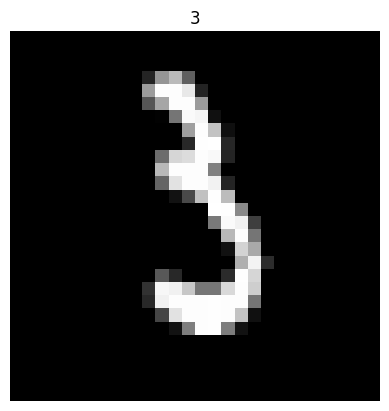

In [216]:
random_idx = np.random.randint(1000)

image = x_test[random_idx]
label = y_test[random_idx]


visualize_image(image, label)
input_layer = image.flatten()

In [217]:
_, new_output = forward_pass(input_layer, weights)
norm_new_output = np.array(tf.nn.softmax(new_output)) # transforming the logits to probs
np.argmax(norm_new_output)

6

In [ ]:
new_output

array([ 0.50433666, -0.00832172, -0.35964987,  1.45268183,  0.36296841,
       -0.09697751,  0.24515608,  0.68653464, -0.15607574, -0.07038648])

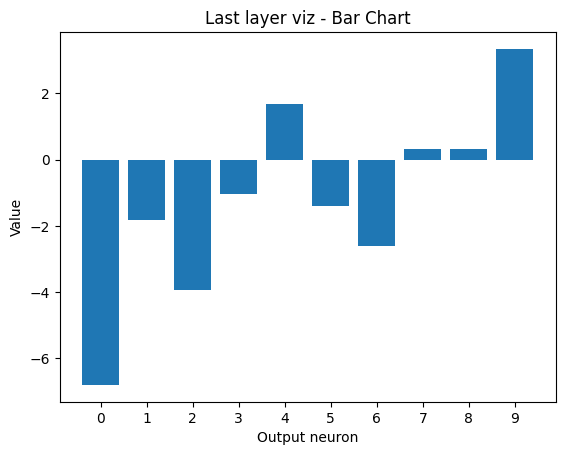

In [209]:
import matplotlib.pyplot as plt

x_indices = range(10)

plt.bar(x_indices, new_output)
plt.xlabel('Output neuron')
plt.ylabel('Value')
plt.title('Last layer viz - Bar Chart')

# Customize x-axis tick labels
plt.xticks(x_indices, x_indices)

plt.show()


In [ ]:
import pickle
import os

root = os.getcwd()

with open(os.path.join(root  ,'new_trained_weights.pkl'), 'wb') as file:
    pickle.dump(weights, file)

In [ ]:
with open(os.path.join(root  ,'trained_weights.pkl'), 'rb') as file:
    var = pickle.load(file)